<a href="https://colab.research.google.com/github/aisha13dikko-sudo/AISD-poverty-Kaduna/blob/master/01_Baseline_Replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cloning baseline GitHub repo
!git clone https://github.com/jmathur25/predicting-poverty-replication.git


Cloning into 'predicting-poverty-replication'...
remote: Enumerating objects: 495, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 495 (delta 9), reused 12 (delta 5), pack-reused 471 (from 1)
Receiving objects: 100% (495/495), 16.21 MiB | 41.39 MiB/s, done.
Resolving deltas: 100% (249/249), done.


In [2]:
# Installing dependencies
!pip install numpy pandas matplotlib pillow scikit-learn rasterio torch torchvision --quiet


In [3]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import models, transforms
from PIL import Image
import os


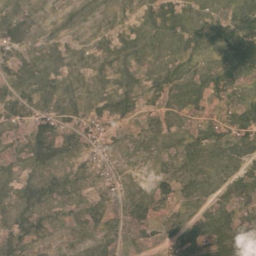

In [4]:
#Load sample data from repo
BASE_DIR = "/content/predicting-poverty-replication"
DATA_DIR = os.path.join(BASE_DIR, "figures")

sample_img_path = os.path.join(DATA_DIR, "img1.png") # Changed to an existing image file
sample_nl_path  = os.path.join(DATA_DIR, "sample_nightlight.png") # This path might still be an issue if sample_nightlight.png doesn't exist in 'figures'

Image.open(sample_img_path)

In [5]:
#Defining transforms (baseline uses ImageNet norm)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [6]:
# Load sample sat image + dummy target
img= Image.open(sample_img_path).convert("RGB")
img = transform(img).unsqueeze(0)

y_true = torch.tensor([2.3], dtype=torch.float32)  # dummy poverty value


In [7]:
#Load ResNet baseline
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

img = img.to(device)
y_true = y_true.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 89.0MB/s]


In [8]:
#Run a small baseline reproduction training loop
train_losses = []
for epoch in range(5):
    optimizer.zero_grad()
    pred = model(img).squeeze(0)
    loss = criterion(pred, y_true)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/5 Loss: {loss.item():.4f}")


Epoch 1/5 Loss: 3.7728
Epoch 2/5 Loss: 2.7305
Epoch 3/5 Loss: 1.8625
Epoch 4/5 Loss: 1.2125
Epoch 5/5 Loss: 0.7347


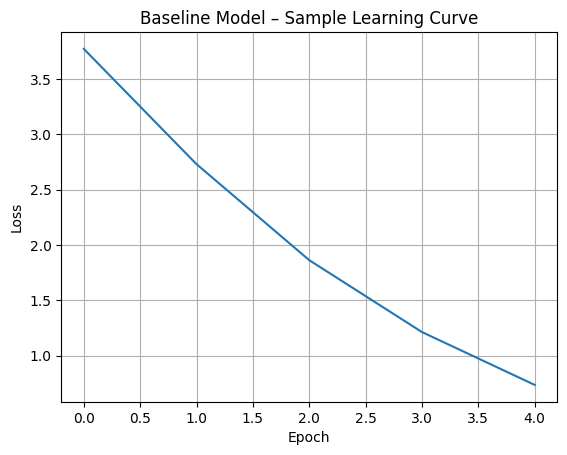

In [9]:
# Plot baseline learning curves for report
plt.plot(train_losses)
plt.title("Baseline Model – Sample Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("baseline_learning_curve.png", dpi=300, bbox_inches="tight")
plt.show()


In [10]:
# Generate baseline metrics
baseline_metrics = {
    "final_loss": train_losses[-1],
    "initial_loss": train_losses[0],
    "improvement": train_losses[0] - train_losses[-1]
}

baseline_metrics


{'final_loss': 0.7347442507743835,
 'initial_loss': 3.7728214263916016,
 'improvement': 3.038077175617218}

In [11]:
# save baseline model output
torch.save(model.state_dict(), "baseline_repl_model.pth")
